# Dark Sky Positions direct from Catalogue

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np
from scipy.spatial import distance_matrix

from dl import queryClient as qc
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# timer function
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


## Querying tractor catalogue for one degree squares

In [ ]:
@timer
def query_tractor(ra, dec, query_dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + query_dist
    dec_min=dec
    dec_max = dec + query_dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

## Get bitmask info

In [ ]:
@timer
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
    

## Process mask and catalog data together

In [ ]:
@timer
def mask_radius(mag_g, mask_minimum=20):
    return (mask_minimum/3600) + 1630./3600. * 1.396**(-mag_g)

In [ ]:
@timer
def combine_data(masked_stars, catalog_stars, coords, mask_minimum=20):
    
    # cut masked stars to only use the same area as catalog_stars
    masked_box = masked_stars.query('(@coords[0] < ra < @coords[1]) and (@coords[2] < dec < @coords[3])')
    
    # apply buffer radius to mask and star data
    masked_box.loc[:, 'radius'] = masked_box['radius'] + (mask_minimum / 3600.)
    catalog_stars['radius'] = mask_radius(catalog_stars['mag_g'], mask_minimum)
    
    # remove g mag
    catalog_stars = catalog_stars.drop('mag_g', axis=1)
    
    # combine catalog + mask
    all_stars = pd.concat([masked_box, catalog_stars]).reset_index(drop=True)
    return all_stars

In [7]:
def create_pixel_columns(masked_stars, catalog_stars, coords, dim):
    """Creates columns for min and max ra and dec for all stars in the dataframe"""

    all_stars = combine_data(masked_stars, catalog_stars, coords, mask_minimum=20)

    # find max and min ra/dec corresponding to the mask of star
    all_stars['max_ra'] = all_stars['ra'] + all_stars['radius']
    all_stars['min_ra'] = all_stars['ra'] - all_stars['radius']
    all_stars['max_dec'] = all_stars['dec'] + all_stars['radius']
    all_stars['min_dec'] = all_stars['dec'] - all_stars['radius']
    
    # boolean for radii that go above 1-degree integer RA/DEC bounds
    expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'
    all_stars['overlap'] = all_stars.eval(expression)
    
    # ra, dec, and radius in pixels
    # TODO check if off by one is needed?
    all_stars['ra_pix'] = np.round((all_stars['ra'] - coords[0]) * dim).astype(int) - 1
    all_stars['dec_pix'] = np.round((all_stars['dec'] - coords[2]) * dim).astype(int) - 1
    all_stars['rad_pix'] = np.ceil(all_stars['radius'] * dim).astype(int)
    
    all_stars['min_ra_pix'] = all_stars['ra_pix'] - all_stars['rad_pix']
    all_stars['max_ra_pix'] = all_stars['ra_pix'] + all_stars['rad_pix']
    all_stars['min_dec_pix'] = all_stars['dec_pix'] - all_stars['rad_pix']
    all_stars['max_dec_pix'] = all_stars['dec_pix'] + all_stars['rad_pix']
    
    # set stars outside of map range to that value
    all_stars.loc[all_stars['min_ra_pix'] < 0, 'min_ra_pix'] = 0
    all_stars.loc[all_stars['max_ra_pix'] > dim, 'max_ra_pix'] = dim
    all_stars.loc[all_stars['min_dec_pix'] < 0, 'min_dec_pix'] = 0
    all_stars.loc[all_stars['max_dec_pix'] > dim, 'max_dec_pix'] = dim
    
    return all_stars

## Segmentation map

In [ ]:
@timer
def seg_map(df:pd.DataFrame, dim, coords):
    # coords = [ra, ra+map_dist, dec, dec+map_dist] 

    array = np.zeros((dim, dim), dtype=int)
    array.flatten()
    
    for star in df.to_dict('records'):
        
        center = [[star['dec_pix'], star['ra_pix']]]
        # print(center)
        
        # make array of indexes
        chunk = np.indices((star['max_dec_pix'] - star['min_dec_pix'], star['max_ra_pix'] - star['min_ra_pix']))
        # adjust indices to correspond to the larger grid
        coord_grid = np.dstack((chunk[0]+star['min_dec_pix'], chunk[1]+star['min_ra_pix']))
        coord_grid = np.concatenate(coord_grid, axis=0)
        # coord grid is shaped like [ [x1, y1], [x1, y2], ... [x1, yn], [x2, y1], ... [xn, yn] ]
        # print(coord_grid)
        
        # calculate distances of each pixel coordinate to the center pixel
        # array is like [ [dist(x1,y1)], [dist(x1,y2)], ... [dist(x1, yn)], ...]
        distances = distance_matrix(x=coord_grid, y=center)

        np.place(array[star['min_dec_pix']:star['max_dec_pix'], star['min_ra_pix']:star['max_ra_pix']], distances < star['rad_pix'], 1)

    array.reshape((dim, dim))
    return array

In [ ]:
@timer
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [ ]:
@timer
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [11]:
#@timer
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [12]:
#@timer
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [13]:
#@timer
def find_overlapping_extent(ra, dec, all_stars):
    # grab everything in a 1 degree square
    print(f"Finding everything within the square RA=({ra}, {ra+1}) and DEC=({dec}, {dec+1})")
    
    degree_masks = all_stars.query(f'({ra} < ra < {ra+1}) & ({dec} < dec < {dec+1})')

    min_ra = degree_masks['min_ra'].min()
    min_dec = degree_masks['min_dec'].min()
    max_ra = degree_masks['max_ra'].max()
    max_dec = degree_masks['max_dec'].max()
    
    return min_ra, min_dec, max_ra, max_dec

In [14]:
@timer
def generate_dark_sky_catalogue(ra, dec, query_dist=1.0, map_dist=1.0, fov=45):
    """Generates a dataframe of RA/DEC pairs corresponding to allowed dark positions
    
    Parameters
    ----------
    ra: `float`
        starting right ascension to query/analyze from (degrees)
    dec: `float`
        starting declination to query/analyze from (degrees)
    query_dist: `float`
        length of one side of the queried square region of sky from starting ra/dec (degrees, default=1)
    map_dist: `float`
        length of one side of the analyzed square region of sky from starting ra/dec (degrees, default=1)
    mask_min_radius: `float`
        minimum masking radius for detected objects (arcseconds, default=20)
    fov: `float`
        minimum spacing between dark sky regions (arcseconds, default=45)
    """
    
    dim = int((3600*4) * map_dist)
    coords = [ra, ra+map_dist, dec, dec+map_dist]
    
    # load masked data
    #print("Loading masked star data....")
    masked_stars = load_mask_data(load_all=True)
    
    #print(f"Querying the tractor catalog for stars from RA({ra}, {ra+query_dist}) to DEC({dec}, {dec+query_dist})...")
    catalog_stars = query_tractor(ra, dec, query_dist)
    
    # concatenate data
    #print("Combining mask and queried stars...")
    all_stars = create_pixel_columns(masked_stars, catalog_stars, coords, dim)

    #print("Creating segmentation map...")
    array = seg_map(all_stars, dim, coords)

    #print("Defining grid lines...")
    gridlines = define_grid(dim, fov)

    #print("Finding dark regions...")
    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    #print("Plotting dark regions...")
    #pix_coords = [all_stars['ra_pix'], all_stars['dec_pix'], all_stars['rad_pix']]
    #create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    #print("Converting dark regions to coordinates...")
    dark_catalogue = create_data_frame(dark_regions, coords, dim)

    #print("Finding overlaps...")
    overlap = find_overlapping_extent(ra,dec,all_stars)
    
    #print("Done!")

    return dark_catalogue, overlap

In [15]:
# 3 deg range
ra_range = np.arange(2,7,1)
dec_range = np.arange(-12,-6,1)

In [16]:
coord_grid = np.meshgrid(ra_range, dec_range)
ra_coords = coord_grid[0].flatten()
dec_coords = coord_grid[1].flatten()

three_deg_cat = pd.DataFrame(columns=['ra','dec'])
overlap_store = []

for ra,dec in zip(ra_coords,dec_coords):
    cat, overlap = generate_dark_sky_catalogue(ra,dec)
    three_deg_cat = pd.concat([three_deg_cat,cat],axis=0).reset_index(drop=True)
    overlap_store.append(overlap)
    print('Added (' + str(ra) + ', ' + str(dec) + ') to catalogue')

Finding everything within the square RA=(2, 3) and DEC=(-12, -11)
Elapsed time: 14.4880 seconds
Added (2, -12) to catalogue


/var/folders/6g/03kjn0jj0f1gfscsfx7_n9l00000gn/T/ipykernel_30035/880280804.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  three_deg_cat = pd.concat([three_deg_cat,cat],axis=0).reset_index(drop=True)


Finding everything within the square RA=(3, 4) and DEC=(-12, -11)
Elapsed time: 14.6085 seconds
Added (3, -12) to catalogue
Finding everything within the square RA=(4, 5) and DEC=(-12, -11)
Elapsed time: 13.9356 seconds
Added (4, -12) to catalogue
Finding everything within the square RA=(5, 6) and DEC=(-12, -11)
Elapsed time: 13.9259 seconds
Added (5, -12) to catalogue
Finding everything within the square RA=(6, 7) and DEC=(-12, -11)
Elapsed time: 14.8619 seconds
Added (6, -12) to catalogue
Finding everything within the square RA=(2, 3) and DEC=(-11, -10)
Elapsed time: 14.2277 seconds
Added (2, -11) to catalogue
Finding everything within the square RA=(3, 4) and DEC=(-11, -10)
Elapsed time: 14.3009 seconds
Added (3, -11) to catalogue
Finding everything within the square RA=(4, 5) and DEC=(-11, -10)
Elapsed time: 13.7166 seconds
Added (4, -11) to catalogue
Finding everything within the square RA=(5, 6) and DEC=(-11, -10)
Elapsed time: 13.8300 seconds
Added (5, -11) to catalogue
Finding 

In [19]:
# left bottom right top
catalogue = three_deg_cat.copy()

for ra,dec,i in zip(ra_coords,dec_coords,range(len(overlap_store))):
    for x,y in zip(catalogue['ra'],catalogue['dec']):
        if x>ra and x<(ra+1):
            if (y<=dec and y>=overlap_store[i][1]) or (y>=(dec+1) and y<=overlap_store[i][3]):
                j = catalogue[(catalogue.dec == y)].index
                catalogue.drop(np.array(j),inplace=True)
        if y>dec and y<(dec+1):
            if (x<=ra and x>overlap_store[i][0]) or (x>=(ra+1) and x<=overlap_store[i][2]):
                j = catalogue[(catalogue.ra == x)].index
                catalogue.drop(np.array(j),inplace=True)

catalogue

,ra,dec
0,2.00625,-11.95625
1,2.00625,-11.88125
2,2.00625,-11.86875
3,2.00625,-11.71875
4,2.00625,-11.61875
...,...,...
33799,6.99375,-6.28125
33800,6.99375,-6.26875
33801,6.99375,-6.21875
33802,6.99375,-6.11875


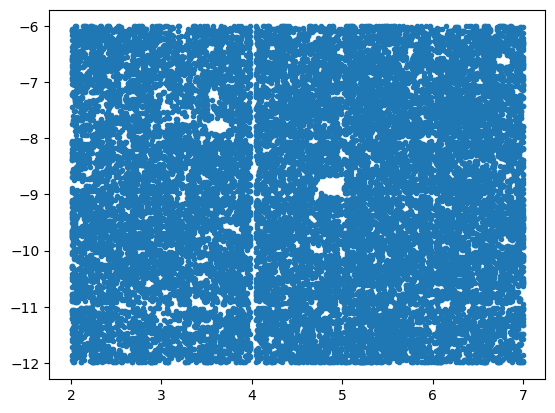

In [20]:
ra_final = catalogue['ra']
dec_final = catalogue['dec']

plt.plot(ra_final,dec_final,'.')